# Model Training

### 1.0 Proprocessing

In [4]:
import os
import random
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import sys
import shutil
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

maxPowerLimit = 25 # Maximum power limit of the solar panel. If power exceeds this level it will be capped

In [2]:
def moving_average(a, n=3):
    ''' Calculate the moving average
    Args:
        a: numpy array (need to vectorize the fucntion to use it with numpy arrays)
        n: rolling window size
    Returns:
        Rolling averaged array (length will be reduced by a width of one rolling window)
    '''
    ret = np.cumsum(a, dtype='f8')
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
def PowerCategorize(value, mapMin=0, mapMax=maxPowerLimit, divisions=5):
    ''' Catagorize a given power value into separate bins
    Args:
        value: input power value (should be between 0-maxPowerLimit)
        mapMin: min power level
        mapMax: maximum power level
        divisions: how many levels(bins) 
    Returns:
        bin number
    '''
    minDiv = (mapMax-mapMin)/divisions
    if value > mapMax: return (divisions-1)
    elif value < mapMin: return 0
    else:
        for t in range(divisions):
            if t*minDiv <= value <= ((t+1)*minDiv): return t        
    print(f'Error Categorizing: {mapMin} < {value} < {mapMax}')

In [4]:
def rescale(img, ratio):
    ''' Rescale the input image according to the ratio given
    Args:
        img: input img array
        ratio: scale ration( 0.1=10%)
    Returns:
        scaled image array
    '''
    width = int(img.shape[1] * ratio)
    height = int(img.shape[0] * ratio)
    dsize = (width, height)
    return cv.resize(img, dsize)

In [19]:
def progressbar(it, prefix="", size=60, out=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        print(f"{prefix}[{u'◼'*x}{('.'*(size-x))}] {j}/{count}", end='\r', file=out, flush=True)
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    print("\n", flush=True, file=out)

(3951,) (3951,) (3932,)


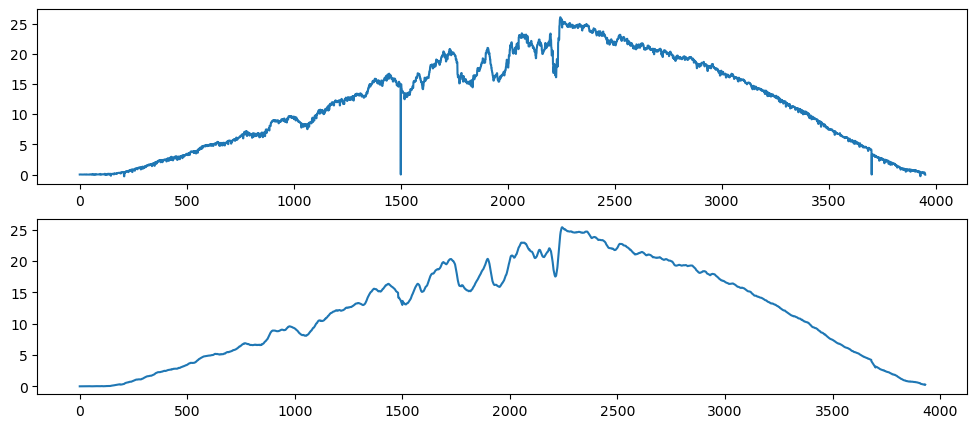

In [6]:
_date = os.listdir('./Data')[-1]
ft = np.genfromtxt(f'./Data/{_date}/{_date}.csv', delimiter=', ', usecols=(0), dtype=str)
p = np.genfromtxt(f'./Data/{_date}/{_date}.csv', delimiter=', ', usecols=(1), dtype=float)
ma_p = moving_average(p,n=20)
print(ft.shape, p.shape, ma_p.shape)
fig,ax =  plt.subplots(2,1, figsize=(12,5))
ax[0].plot(p)
ax[1].plot(ma_p)
plt.show()

In [7]:
def plotData(date, raw_data, avg_data, randomFrame, nos_frames, cat_divisions, leap, avg_plot_title):
    ''' Plot the power level throughout the day while highlighting the randomly selected clip window
    Args:
        date: data collection date (string, for plot title)
        raw_data: numpy array of the plot data (first plot)
        avg_data: rolling averaged data (secong plot)
        randomFrame: randomply selected frame (int)
        nos_frames:  number of frames per clip
        cat_divisions: number of bins
        leap: future window of powerlevel extraction
        avg_plot_title: second plot title
    '''
    vectorized_powerCat = np.vectorize(PowerCategorize)
    power_cat = vectorized_powerCat(avg_data) # Convert the function into vectorizes so that it can be applied to numpy arrays

    fig,ax =  plt.subplots(3,1, figsize=(12,10),sharex=True)
    x1 = np.arange(0,len(raw_data),1)
    ax[0].fill_between(x1,raw_data, color="skyblue", alpha=0.4)
    ax[0].plot(x1, raw_data, color="Slateblue",alpha=0.8, linewidth=1)
    ax[0].set_title(f'Solar Power Generation: {date}',size=20)
    ax[1].plot(avg_data)
    ax[1].set_title(f'{avg_plot_title}',size=12)
    
    ax[1].axvspan(randomFrame, randomFrame+nos_frames, color="green", alpha=0.6)
    ax[1].axvspan(randomFrame+nos_frames,randomFrame+nos_frames+leap, color="red", alpha=0.4)
    ax[2].plot(power_cat)
    ax[2].set_title(f'Categorized Power levels: {cat_divisions}',size=12)
    ax[2].axvspan(randomFrame, randomFrame+nos_frames, color="green", alpha=0.6)
    ax[2].axvspan(randomFrame+nos_frames,randomFrame+nos_frames+leap, color="red", alpha=0.4)
    clear_output(wait = False)
    plt.show()

In [8]:
def dataContinutyTest(arr, sep='_', minDataCountPerHour=330,debug=False):
    ''' Test the data for any discontinuties due to power outages and system failures
    Args:
        arr: numpy time array
        sep: digit separater symbol
        minDataCountPerHour: number of minimum data point captured per hour
    Returns:
        Start and End frames of the longest continuous data stream
    '''
    out_arr = np.char.split(arr, sep=sep)
    count = [0,0,0,0,0,0,0,0,0,0,0,0,0]
    start = 0
    end = 0
    total = 0
    for i in out_arr:
        h = int(i[0])
        count[h-6] += 1
    if debug: print(count)
    check = [1 if i > minDataCountPerHour else 0  for i in count]
    baseStr= ""
    for p in check:
        baseStr += str(p)
    if debug: print (baseStr)
    testStr = "111111111111"
    for i in reversed(range(len(count))):
        id = baseStr.find(testStr[:i])
        if id != -1: 
            start = id
            end = id+i
            break
    startFr = (sum(count[:start])+10) # Skipped 10 frames to settle down the exposure
    endFr = (sum(count[:end])-1)
    if debug: print(count[start:end])
    return startFr, endFr

In [9]:
_date = os.listdir('./Data')[-1]
frame_time = np.genfromtxt(f'./Data/{_date}/{_date}.csv', delimiter=', ', usecols=(0), dtype=str)
startFr, endFr = dataContinutyTest(frame_time,debug=True)
print(startFr,endFr)

[334, 337, 338, 338, 296, 337, 337, 336, 337, 337, 337, 286, 1]
1111011111100
[337, 337, 336, 337, 337, 337]
1653 3663


In [10]:
def generateClips(nos_clips, nos_frames, leap, cat_divisions, frame_rescale_ratio, imgPath, videoPath,fps=12, plotShow=False, original_frame_size=(2592,1944), rollingWindow=40):
    ''' Generate video clips form a image sets separated with dates. After completing one video creation pass, 
        it will note the last image directory so that it will only create videos from the newly added image directories.

    Args: 
        nos_clips:      Number of clips
        nos_frames:     Number of frames pe clip
        leap:           Shift from randomly selected frame to calculate the future average power
        cat_divisions:  Power categorize bin count   
        frame_rescale_ratio: Video rescale ratio (0.1=10%)
        imgPath:        Path to the image set separed by date
        videoPath:      Path to store generated video clips
        fps:            Frame rate of the clips generated
        plotShow:       Show plot with detaiils of the each generated clip (boolean) 
        original_frame_size: Tuple of the original image dimension (width,height)
    '''
    dateList = sorted(os.listdir(imgPath))
    if os.path.exists(videoPath) and os.path.exists(f'{videoPath}/log.txt'): # videos has been created yet and has a log file
        with open(f'{videoPath}/log.txt') as file:
            lastEntry = file.readlines()[-1].replace('\n','')
            if lastEntry in dateList: 
                dateIdx = dateList.index(lastEntry)
                print('[Warning]: Previous video creation logs found! Starting from the Last stop...')
                dateList = dateList[dateIdx:]
            else: print('[Warning]: log file error! Starting from the begining...')
    print(f'Total number of dates: {len(dateList)}')
    counter = '0001'
    for numDate, date in enumerate(dateList):
        frame_time = np.genfromtxt(f'{imgPath}/{date}/{date}.csv', delimiter=', ', usecols=(0), dtype=str)
        power = np.genfromtxt(f'{imgPath}/{date}/{date}.csv', delimiter=', ', usecols=(1), dtype=float)
        ma_power = moving_average(power, n=rollingWindow) # length of the moving average will be less than the input lenght by the length of the window
        # print(frame_time.shape, power.shape, ma_power.shape)
        con_start, con_end = dataContinutyTest(frame_time,debug=False)
        totalContinuousData = con_end - con_start
        dataLoss = len(frame_time) - totalContinuousData
        dataLossPer = (dataLoss*100 / len(frame_time))

        if totalContinuousData > 1500:
            # for i in range(nos_clips):
            for i in progressbar(range(nos_clips), prefix=f'{numDate+1}. [{date}] [Data loss = {dataLoss}({dataLossPer:.1f}%)] - Generating: ', size=40):
                randomFrame = random.randint(con_start,(con_end-(leap+nos_frames+rollingWindow))) # limit the end range to moving average power shape
                frame_seq = []
                future_acc_power = 0
                current_acc_power = 0
                # print(f'totalFrame:{len(ma_power)} randomFrame:{randomFrame} futureFrame:{randomFrame+leap+nos_frames}')
                
                for i in range(nos_frames):
                    frame_seq.append(f'{imgPath}/{date}/' + frame_time[randomFrame+i] + '.jpg')
                    current_acc_power += ma_power[randomFrame+i] # Accumelate the future power value
                    future_acc_power += ma_power[randomFrame+leap+i] # Accumelate the future power value

                crnt_avg_power = current_acc_power/nos_frames
                future_average_power = future_acc_power/nos_frames

                crntCategory = PowerCategorize(crnt_avg_power, divisions=cat_divisions)
                futureCategory = PowerCategorize(future_average_power, divisions=cat_divisions)

                vid_label = str(crntCategory)
                store_dir = f'{videoPath}/{vid_label}'
                if not os.path.exists(store_dir): os.makedirs(store_dir)
                    
                if len(os.listdir(store_dir)) > 0: 
                    last_labelName = sorted(os.listdir(store_dir))[-1]
                    n = int(last_labelName[2:6])
                    counter = (str(n+1)).zfill(4)
                else: counter = '0001'

                avg_plot_title = f'{crntCategory}({crnt_avg_power:.1f})-{futureCategory}({future_average_power:.1f})'
                if plotShow :plotData(date=date, 
                                        raw_data=power, 
                                        avg_data=ma_power, 
                                        randomFrame=randomFrame, 
                                        nos_frames=nos_frames, 
                                        cat_divisions=cat_divisions, 
                                        leap=leap, 
                                        avg_plot_title=avg_plot_title)
                
                lowRes_frame = tuple([int(frame_rescale_ratio*x) for x in original_frame_size])
                out = cv.VideoWriter(f'{store_dir}/{vid_label}_{counter}.avi', cv.VideoWriter_fourcc(*'DIVX'), fps, lowRes_frame)

                for imgName in frame_seq:
                    img = rescale(cv.imread(imgName), frame_rescale_ratio)
                    out.write(img)
        else: print(f'[{date}] Skipped due to having too much data losses')
        with open(f'{videoPath}/log.txt', 'w') as log: log.write(date)
    print('-- Done --')

In [11]:
generateClips(nos_clips=500, 
                nos_frames=15,
                leap=15,        # keep the [leap = nos_frames] for experiment 01
                cat_divisions=3,
                frame_rescale_ratio=0.2,
                imgPath='./Data',
                videoPath='./Videos',
                fps=15,
                plotShow=False
                )

[Warning]: Previous video creation logs found! Starting from the Last stop...
Total number of dates: 8
1. [2023-01-03] [Data loss = 310(7.7%)] - Generating: [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 500/500

2. [2023-01-05] [Data loss = 955(24.0%)] - Generating: [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 500/500

3. [2023-01-06] [Data loss = 331(8.2%)] - Generating: [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 500/500

4. [2023-01-07] [Data loss = 89(3.2%)] - Generating: [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 500/500

5. [2023-01-09] [Data loss = 597(20.3%)] - Generating: [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 500/500

6. [2023-01-10] [Data loss = 330(8.2%)] - Generating: [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 500/500

7. [2023-01-11] [Data loss = 316(7.9%)] - Generating: [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 500/500

8. [2023-01-12] [Data loss = 1941(49.1%)] - Generating: [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 500/500

-- Done --


In [12]:
!find ./Videos

./Videos
./Videos/0
./Videos/0/0_0001.avi
./Videos/0/0_0002.avi
./Videos/0/0_0003.avi
./Videos/0/0_0004.avi
./Videos/0/0_0005.avi
./Videos/0/0_0006.avi
./Videos/0/0_0007.avi
./Videos/0/0_0008.avi
./Videos/0/0_0009.avi
./Videos/0/0_0010.avi
./Videos/0/0_0011.avi
./Videos/0/0_0012.avi
./Videos/0/0_0013.avi
./Videos/0/0_0014.avi
./Videos/0/0_0015.avi
./Videos/0/0_0016.avi
./Videos/0/0_0017.avi
./Videos/0/0_0018.avi
./Videos/0/0_0019.avi
./Videos/0/0_0021.avi
./Videos/0/0_0022.avi
./Videos/0/0_0023.avi
./Videos/0/0_0024.avi
./Videos/0/0_0025.avi
./Videos/0/0_0026.avi
./Videos/0/0_0027.avi
./Videos/0/0_0028.avi
./Videos/0/0_0029.avi
./Videos/0/0_0030.avi
./Videos/0/0_0031.avi
./Videos/0/0_0032.avi
./Videos/0/0_0033.avi
./Videos/0/0_0034.avi
./Videos/0/0_0035.avi
./Videos/0/0_0036.avi
./Videos/0/0_0037.avi
./Videos/0/0_0038.avi
./Videos/0/0_0039.avi
./Videos/0/0_0041.avi
./Videos/0/0_0042.avi
./Videos/0/0_0043.avi
./Videos/0/0_0044.avi
./Videos/0/0_0045.avi
./Videos/0/0_0046.avi
./Videos/0/0

## Split the dataset

In [23]:
def dataSplit(clipPath, storeDir, testRatio=0.2, validateRatio=0.2,trainRatio=0.6,):
    subsets = ['test','validate','train']
    clipCount = []
    clipNames = []
    testNames = []
    validateNames = []
    trainNames = []
    
    dirList = [d for d in os.listdir(clipPath) if os.path.isdir(f'{clipPath}{d}')]
    for i,name in enumerate(dirList):
        dir = clipPath + name
        clipNames.append(os.listdir(dir))
        clipCount.append(len(os.listdir(dir)))
    minClipCount = min(clipCount)

    c1 = int(minClipCount*testRatio)
    c2 = int(minClipCount*testRatio + minClipCount*validateRatio)

    for p,_ in enumerate(clipNames): 
        random.shuffle(clipNames[p]) # Shuffle the names 
        testNames.append(clipNames[p][0:c1])
        validateNames.append(clipNames[p][c1:c2])
        trainNames.append(clipNames[p][c2:minClipCount])
        subsetContent = [testNames,validateNames,trainNames]

    for id,subsetName in enumerate(subsets):
        dirName = f'{storeDir}/{subsetName}/'
        if not os.path.exists(dirName): os.makedirs(dirName)
        for i in range(len(dirList)):
            for u in subsetContent[id][i]:
                vidPath = f'{clipPath}{i}/{u}'
                desPath = f'{dirName}{i}'
                if not os.path.exists(desPath): os.makedirs(desPath)
                shutil.copy(vidPath,desPath)
        print(f'Done Creating: {dirName}')

In [25]:
dataSplit(clipPath='./Videos/', storeDir='./SplitDataset')

Done Creating: ./SplitDataset/test/
Done Creating: ./SplitDataset/validate/
Done Creating: ./SplitDataset/train/


In [28]:
!find ./SplitDataset

/bin/bash: /home/anuradha/anaconda3/envs/tfcpu/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
./SplitDataset
./SplitDataset/test
./SplitDataset/test/0
./SplitDataset/test/0/0_0011.avi
./SplitDataset/test/0/0_0021.avi
./SplitDataset/test/0/0_0041.avi
./SplitDataset/test/0/0_0044.avi
./SplitDataset/test/0/0_0047.avi
./SplitDataset/test/0/0_0059.avi
./SplitDataset/test/0/0_0060.avi
./SplitDataset/test/0/0_0061.avi
./SplitDataset/test/0/0_0063.avi
./SplitDataset/test/0/0_0066.avi
./SplitDataset/test/0/0_0068.avi
./SplitDataset/test/0/0_0075.avi
./SplitDataset/test/0/0_0076.avi
./SplitDataset/test/0/0_0080.avi
./SplitDataset/test/0/0_0087.avi
./SplitDataset/test/0/0_0088.avi
./SplitDataset/test/0/0_0096.avi
./SplitDataset/test/0/0_0103.avi
./SplitDataset/test/0/0_0104.avi
./SplitDataset/test/0/0_0106.avi
./SplitDataset/test/0/0_0108.avi
./SplitDataset/test/0/0_0113.avi
./SplitDataset/test/0/0_0126.avi
./SplitDataset/te

In [ ]:
# testRatio = 0.2
# validateRatio = 0.2
# trainRatio = 0.6
# clipPath = '/media/anuradha/Volume_A/Anuradha/Projects/Solar_Prediction/Src/Videos/'

# clipCount = []
# clipNames = []
# testNames = []
# validateNames = []
# trainNames = []
# for i,name in enumerate(os.listdir(clipPath)):
#     dir = clipPath + name
#     clipNames.append(os.listdir(dir))
#     clipCount.append(len(os.listdir(dir)))
# minClipCount = min(clipCount)

# c1 = int(minClipCount*testRatio)
# c2 = int(minClipCount*testRatio + minClipCount*validateRatio)

# for p,_ in enumerate(clipNames): 
#     random.shuffle(clipNames[p])
#     testNames.append(clipNames[p][0:c1])
#     validateNames.append(clipNames[p][c1:c2])
#     trainNames.append(clipNames[p][c2:minClipCount])

# dirName = './Testing/Test/'
# if not os.path.exists(dirName): os.makedirs(dirName)
# for i in range(5):
#     for u in testNames[i]:
#         vidPath = f'{clipPath}{i}/{u}'
#         desPath = f'{dirName}{i}'
#         if not os.path.exists(desPath): os.makedirs(desPath)
#         shutil.copy(vidPath,desPath)

# dirName = './Testing/Validate/'
# if not os.path.exists(dirName): os.makedirs(dirName)
# for i in range(5):
#     for u in validateNames[i]:
#         vidPath = f'{clipPath}{i}/{u}'
#         desPath = f'{dirName}{i}'
#         if not os.path.exists(desPath): os.makedirs(desPath)
#         shutil.copy(vidPath,desPath)

# dirName = './Testing/Train/'
# if not os.path.exists(dirName): os.makedirs(dirName)
# for i in range(5):
#     for u in trainNames[i]:
#         vidPath = f'{clipPath}{i}/{u}'
#         desPath = f'{dirName}{i}'
#         if not os.path.exists(desPath): os.makedirs(desPath)
#         shutil.copy(vidPath,desPath)
        